# Assignment #5 - Artificial Neural Networks
---
## Name: 李勝維
## Student ID: 0711239
---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import warnings;warnings.filterwarnings("ignore")
np.random.seed(1)
plt.rcParams['figure.dpi'] = 200 # 500

# Data Input & Data Visualization

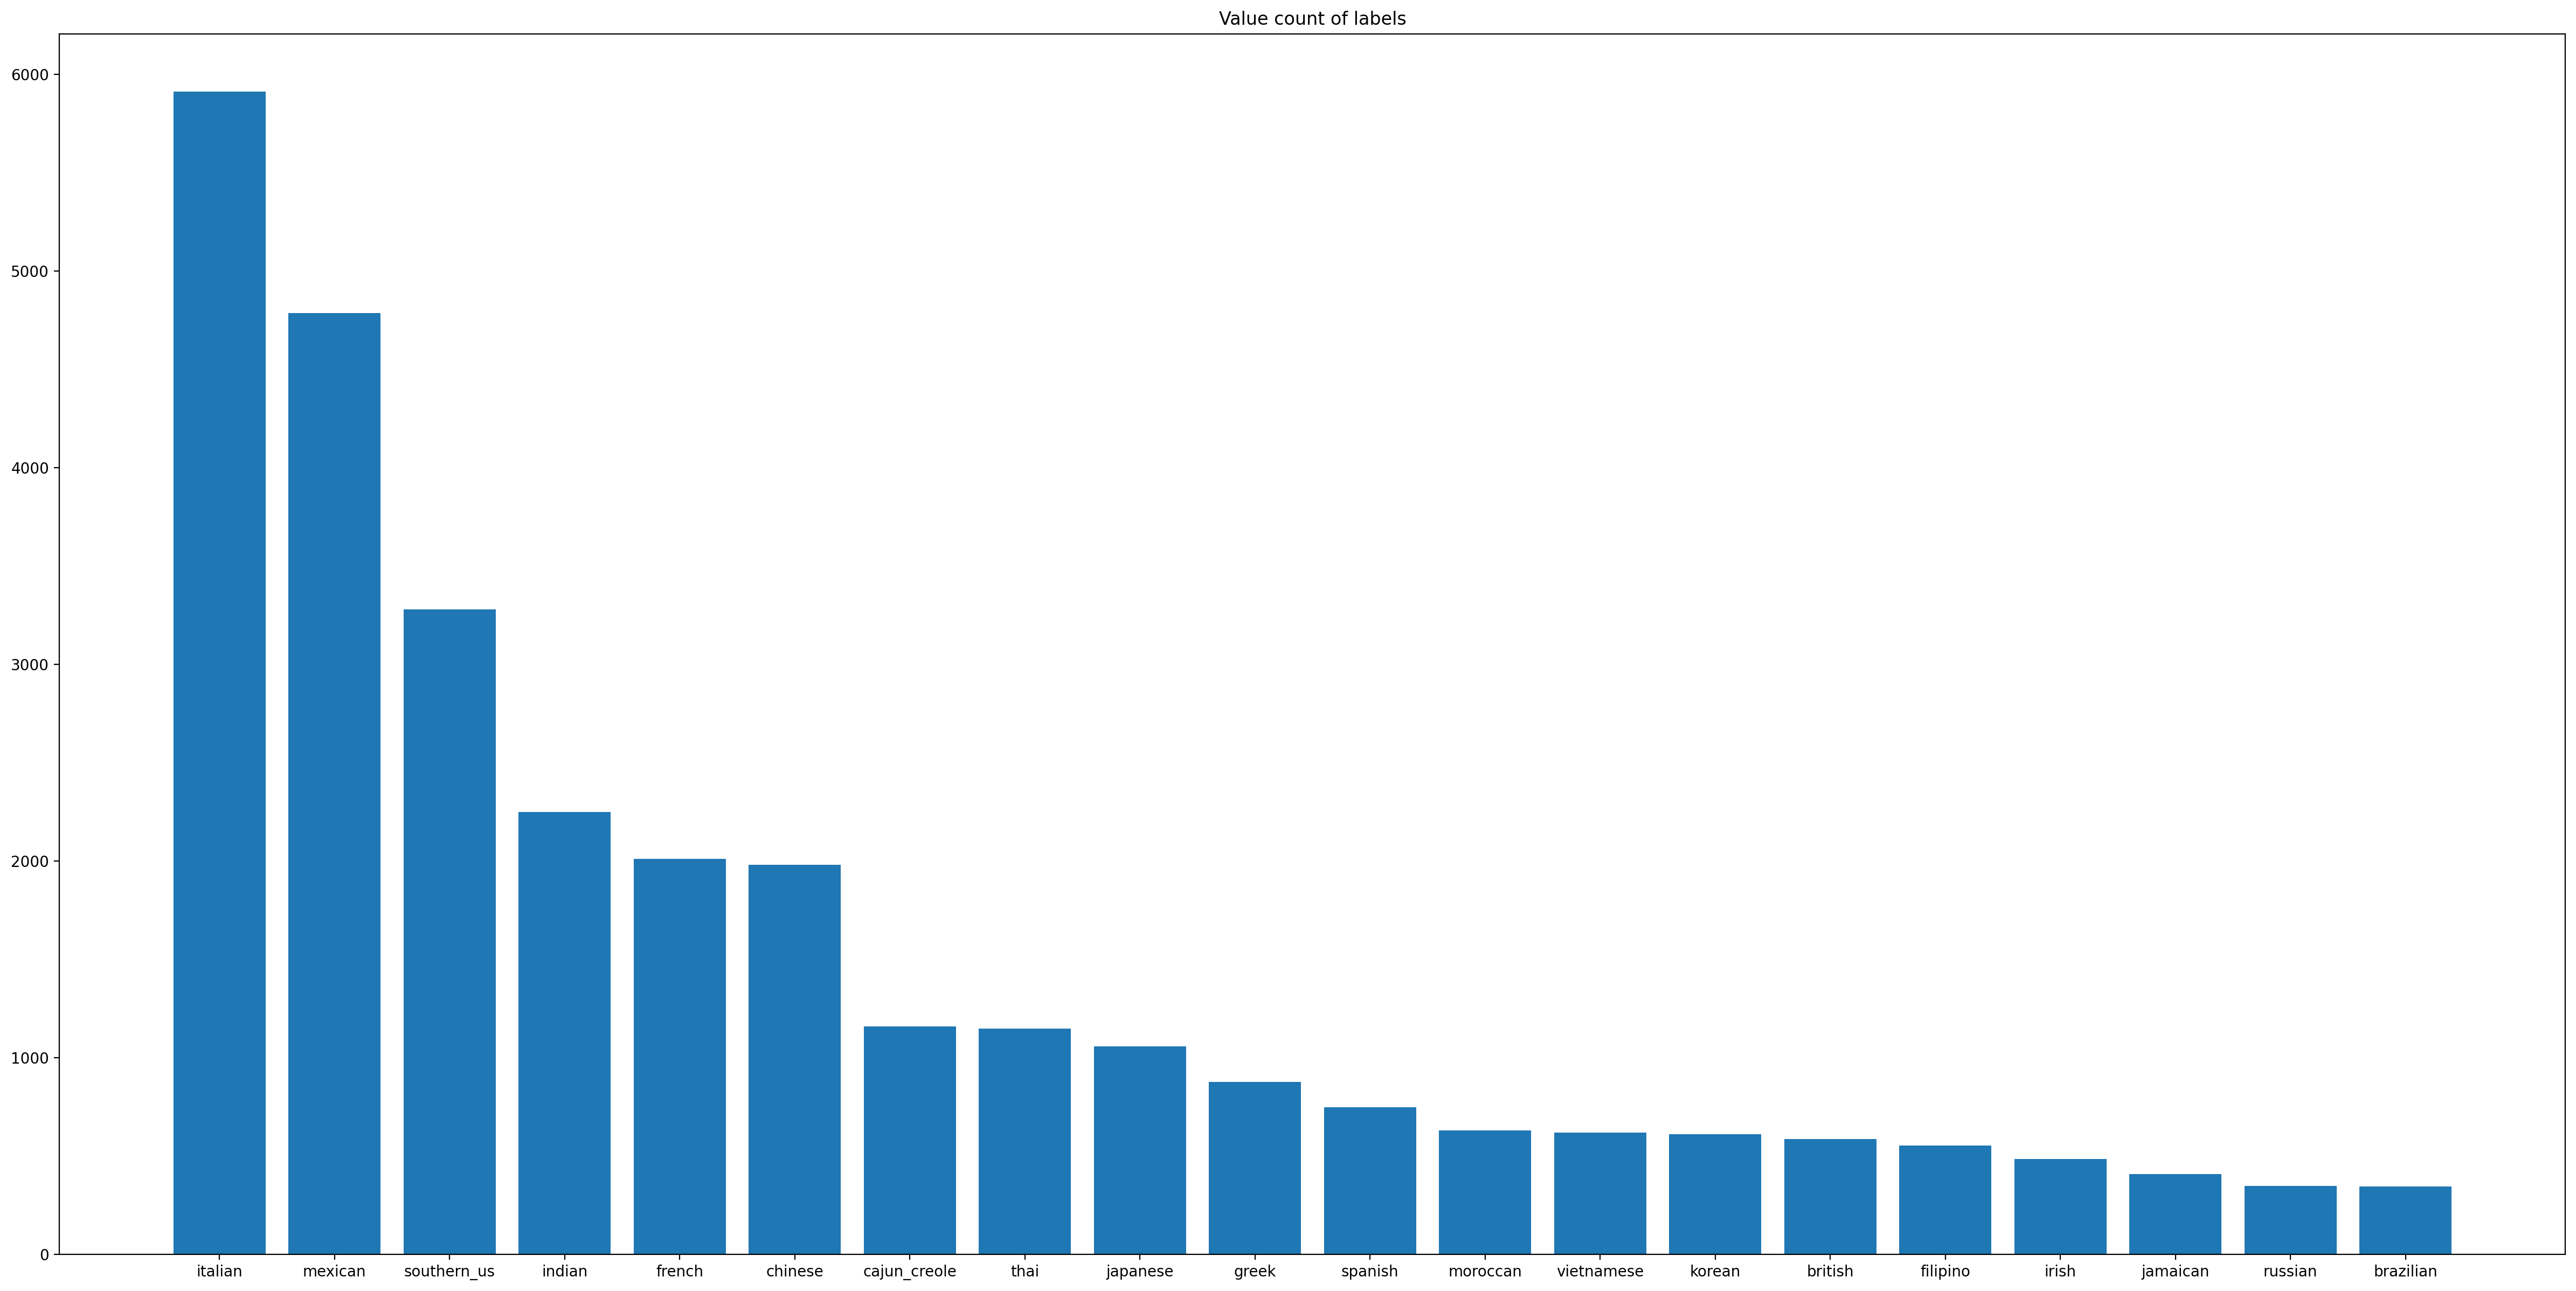

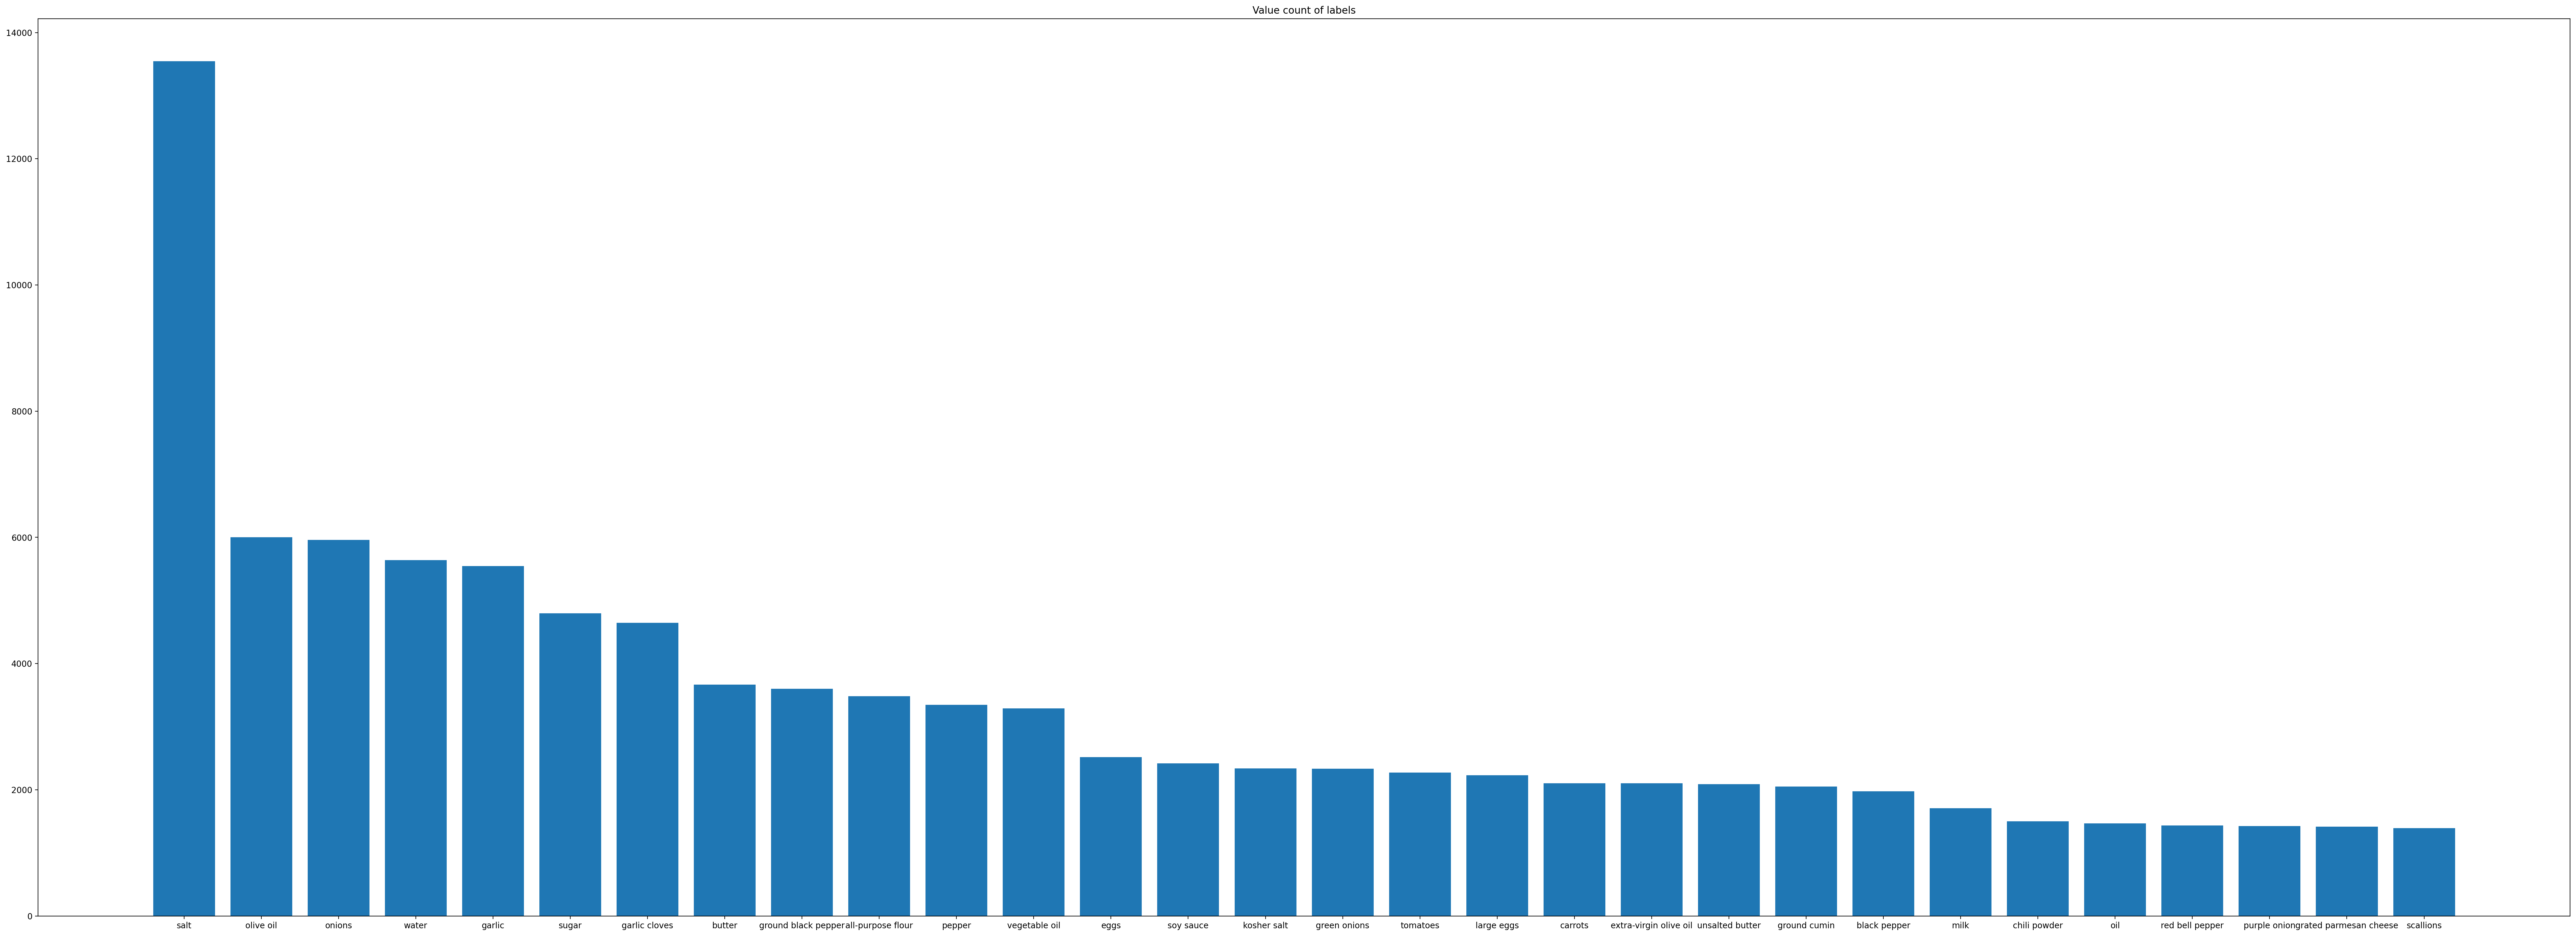

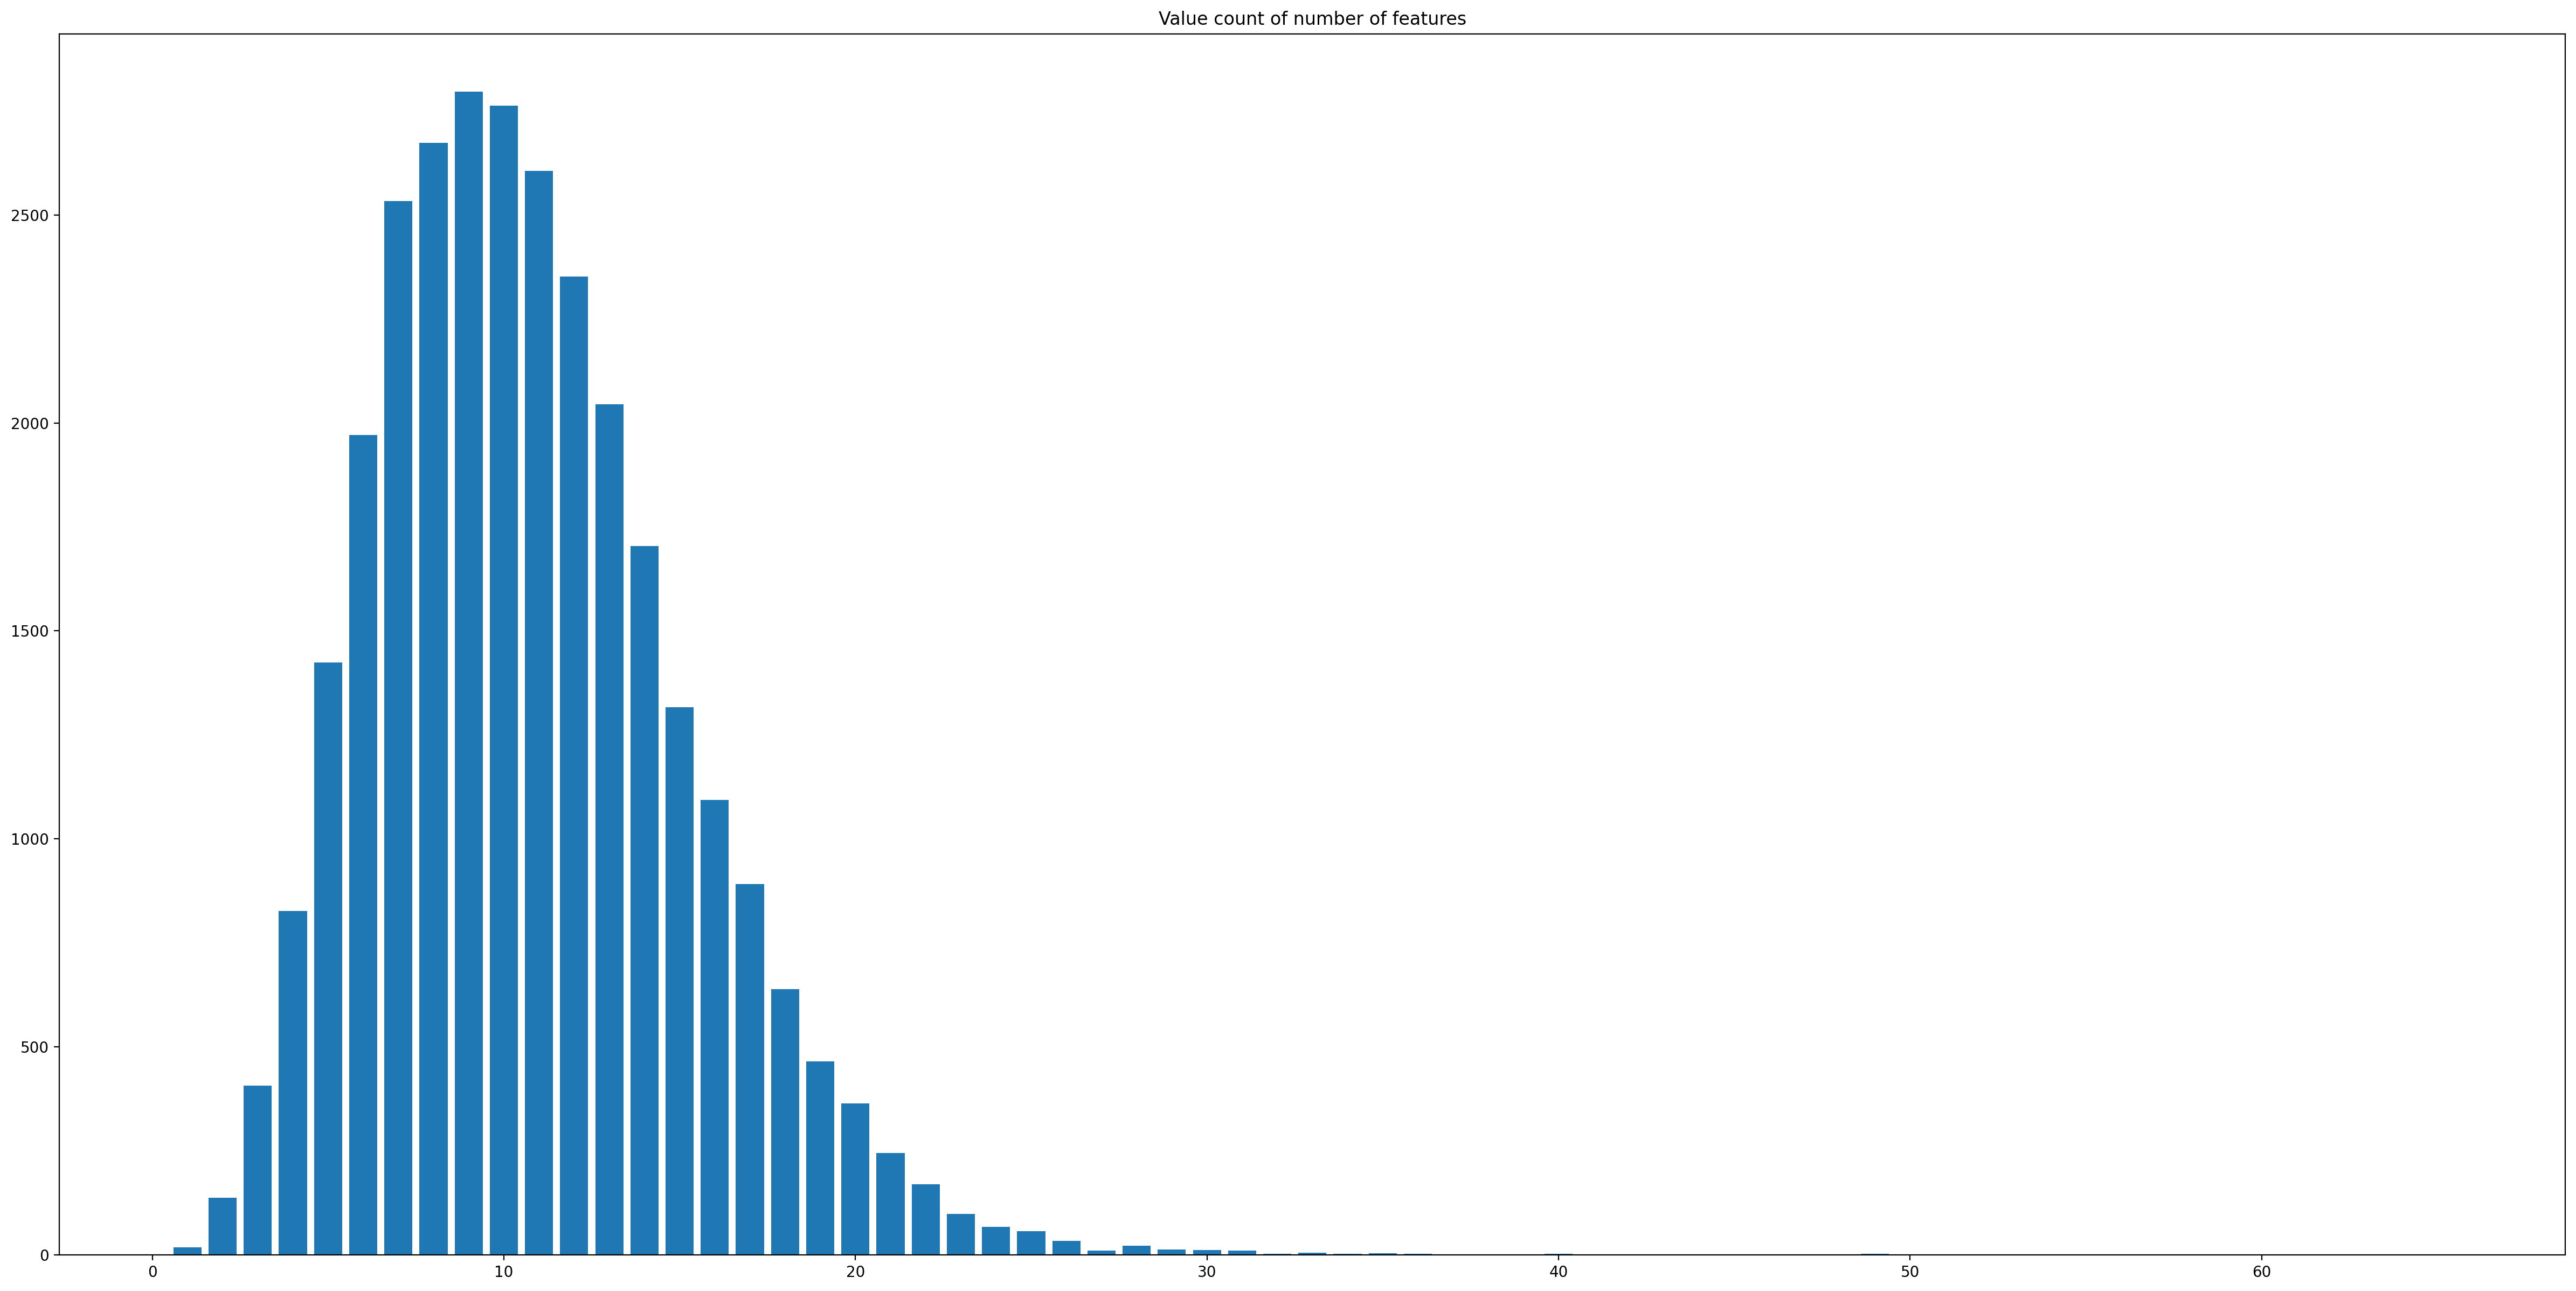

In [2]:
import json
from collections import defaultdict
# Data input
with open('2021-nycu-ml-hw5\\train.json', 'r') as file:
    raw_data = json.load(file)
raw_data = [(x['id'], x['cuisine'], x['ingredients']) for x in raw_data]
ids, cuisines, ingredientss = zip(*raw_data)
df = pd.DataFrame({
    'id':ids,
    'cuisine':cuisines,
    'ingredients':ingredientss,
})

# Data Visualization
# label
count = df['cuisine'].value_counts()
plt.figure(figsize=(30,15))
plt.title("Value count of labels")
plt.bar(count.index, height=count.values)
plt.show()

# features
count = defaultdict(lambda : 0)
for x in df['ingredients']:
    for n in x:
        count[n] += 1
# import pprint;pprint.pprint(count)
# get Top 30 features
count = {k: v for idx, (k, v) in enumerate(sorted(count.items(), key=lambda item: item[1], reverse=True)) if idx < 30}
count = pd.Series(count)
plt.figure(figsize=(55,20))
plt.title("Value count of labels")
plt.bar(count.index, height=count.values)
plt.show()

# number of ingredients
count = defaultdict(lambda : 0)
for x in df['ingredients']:
    count[len(x)] += 1
count = {k: v for (k, v) in sorted(count.items(), key=lambda item: item[1], reverse=True)}
count = pd.Series(count)
plt.figure(figsize=(30,15))
plt.title("Value count of number of features")
plt.bar(count.index, height=count.values)
plt.show()

# Data Preprocessing

In [3]:
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

def Porter_Stemmer(s):
    PS = PorterStemmer()
    stop_words = stopwords.words('english')
    str = ' '.join([PS.stem(w.lower()) for w in s if w not in stop_words])
    return str


# Shuffle data
df = df.sample(frac=1, random_state=0)

# Porter Stemmer
df['concat'] = [Porter_Stemmer(s) for s in df['ingredients']]

# Transform into TF-IDF matrix
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['concat'])
# Encode Y
y_encoder = LabelEncoder()
df['cuisine'] = y_encoder.fit_transform(df['cuisine'])
y = df['cuisine'].values
from pprint import pprint;pprint(dict(enumerate(y_encoder.classes_)))

  (0, 876)	0.1530978984191931
  (0, 2676)	0.1442429324544128
  (0, 149)	0.21326201542726406
  (0, 671)	0.2898537748933088
  (0, 1089)	0.26453135602710104
  (0, 1101)	0.17333391481262242
  (0, 1854)	0.15575710696925807
  (0, 2474)	0.16677001821677542
  (0, 1994)	0.1931733864426337
  (0, 678)	0.10925116967382795
  (0, 1189)	0.1598242342434297
  (0, 1992)	0.10044411750072389
  (0, 866)	0.2476772361450726
  (0, 1264)	0.21805190521650158
  (0, 1417)	0.3540727687000526
  (0, 757)	0.2227540838554249
  (0, 822)	0.3540727687000526
  (0, 344)	0.12327758587447166
  (0, 2662)	0.13167430351708007
  (0, 537)	0.19855269523167446
  (0, 2277)	0.32875034983384477
  (1, 493)	0.16123142414125377
  (1, 1658)	0.2762951758009456
  (1, 2310)	0.24134440885028074
  (1, 2727)	0.16901343396640037
  :	:
  (29772, 1123)	0.1656348838039191
  (29772, 2758)	0.28346573401778197
  (29772, 2746)	0.1817103034648946
  (29772, 2709)	0.19859731847251505
  (29772, 229)	0.15114849925481916
  (29772, 1377)	0.22600808599395988
 

# Artificial Neural Networks

In [4]:
import torch
from torch import nn
import pytorch_lightning as pl
from torch.utils.data import TensorDataset, DataLoader, random_split
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks.early_stopping import EarlyStopping


class MLP(pl.LightningModule):
    def __init__(self) -> None:
        super().__init__()
        self.clf = nn.Sequential(
            nn.Linear(2809, 4096),
            nn.LeakyReLU(0.2),
            nn.Linear(4096, 2048),
            nn.LeakyReLU(0.2),
            nn.Linear(2048, 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024, 20),
        )
        # self.clf = nn.Sequential(
        #     nn.Linear(2809, 1024),
        #     nn.LeakyReLU(0.2),
        #     nn.Linear(1024, 512),
        #     nn.LeakyReLU(0.2),
        #     nn.Linear(512, 128),
        #     nn.LeakyReLU(0.2),
        #     nn.Linear(128, 20),
        # )
        self.criterion = nn.CrossEntropyLoss()

    def forward(self, x):   
        rst = self.clf(x)
        return torch.argmax(rst, 1).cpu().numpy()

    def training_step(self, batch, batch_idx):
        x, y = batch
        y_pred = self.clf(x)
        loss = self.criterion(y_pred, y)
        self.log('Training_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        rst = self.clf(x)
        loss = self.criterion(rst, y)
        self.log('acc_loss', loss)
        y_pred = torch.argmax(rst, 1)
        acc = (y_pred.cpu().numpy() == y.cpu().numpy()).mean()
        self.log('Acc', acc)


    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)

my_dataset = TensorDataset(torch.tensor(X.toarray(), dtype=torch.float32), torch.tensor(y, dtype=torch.long))
train_set, valid_set = random_split(my_dataset, [round(len(my_dataset)*0.7), len(my_dataset)-round(len(my_dataset)*0.7)])
train_loader = DataLoader(train_set, batch_size=1024, shuffle=True, drop_last=False)
valid_loader = DataLoader(valid_set, batch_size=1024, shuffle=False, drop_last=False)

checkpoint_callback = ModelCheckpoint(
    monitor="Acc",
    dirpath="weights",
    filename="{epoch:d}-{Acc:.6f}",
    save_top_k=1,
    mode="max",
)
ES_callback = EarlyStopping(monitor='acc_loss', patience=10)

model = MLP()
trainer = pl.Trainer(gpus=-1, callbacks=[checkpoint_callback, ES_callback], log_every_n_steps=10)
trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=valid_loader)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
-----------------------------------------------
0 | clf       | Sequential       | 22.0 M
1 | criterion | CrossEntropyLoss | 0     
-----------------------------------------------
22.0 M    Trainable params
0         Non-trainable params
22.0 M    Total params
88.076    Total estimated model params size (MB)


Epoch 12: 100%|██████████| 30/30 [00:00<00:00, 32.94it/s, loss=0.052, v_num=0] 
